In [127]:
import torch
import torchvision
import matplotlib.pyplot as plt 
import xitorch

In [32]:
img = torchvision.io.read_image("../data/cat.jpg")
C, H , W = img.shape

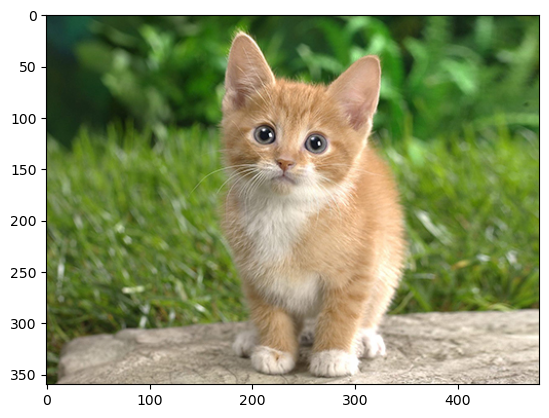

In [4]:
plt.imshow(img.permute(1,2,0))

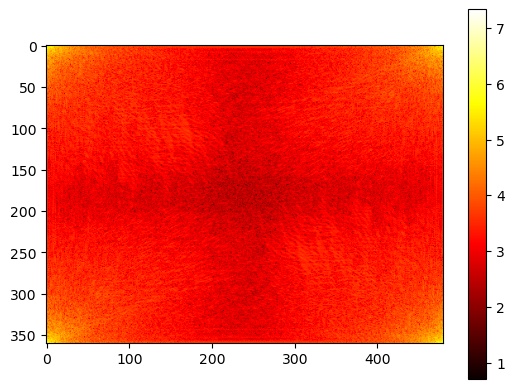

In [31]:
img_freq = torch.fft.fft2(img)
max_val = torch.max(torch.log10(torch.abs(img_freq)))
plt.imshow(torch.log10(torch.abs(img_freq.permute(1,2,0)))[...,0], cmap="hot")
plt.colorbar()


In [164]:
freq = torch.tensor([0]+[2**i for i in range(9)])
#freq = torch.tensor([i for i in range(10)])
freq_basis = lambda coef, xs: torch.sum(torch.stack( c * torch.exp(2j*3.14159*f*xs) for f ,c in zip(freq, coef)), dim=0, keepdim=False)

In [169]:
# logrithmic sample
dwn_freq_H = img_freq[:, freq,  :] # down sample exponentially along H dimension
dwn_freq_W = img_freq[:, :, freq]  # down sample exponentially along W dimension
# ifft
w_H = torch.fft.ifft(dwn_freq_H, dim=2) # inverse fft along W dimension 
W_h = torch.fft.ifft(dwn_freq_W, dim=1) # inverse fft along W dimension 
w_H[:,:,:] /= H 
W_h[:,:,:] /= W
# interpolate in frequency domain (doesn't work, PREF only interpolate along ifft spatial domain)
w_H_interp = torch.cat(tuple((torch.linspace(0,1,freq[i+1]-freq[i]+1).unsqueeze(0).unsqueeze(-1).expand(3,-1,W) * w_H[:,[i+1],:]\
     + torch.linspace(1,0,freq[i+1]-freq[i]+1).unsqueeze(0).unsqueeze(-1).expand(3,-1,W) *w_H[:,[i],:])[:,:-1,:]\
        for i in range(len(freq)-1)), dim=1)
print(w_H_interp.shape)

w_H_interp = torch.cat(tuple((torch.linspace(0,1,freq[i+1]-freq[i]+1).unsqueeze(0).unsqueeze(-1).expand(3,-1,W) * w_H[:,[i+1],:]\
     + torch.linspace(1,0,freq[i+1]-freq[i]+1).unsqueeze(0).unsqueeze(-1).expand(3,-1,W) *w_H[:,[i],:])[:,:-1,:]\
        for i in range(len(freq)-1)), dim=1)
print(w_H_interp.shape)

freq_max = torch.max(freq)



torch.Size([3, 256, 480])


In [170]:
basis_h = torch.stack(list(torch.exp(2j*3.141592*f/H * torch.arange(0,H)) for f in freq)).unsqueeze(-1).expand(3, -1,-1,W)
basis_w = torch.stack(list(torch.exp(2j*3.141592*f/W * torch.arange(0,W)) for f in freq)).unsqueeze(1).expand(3, -1,H,-1)
basis_h.shape, basis_w.shape,  w_H.shape, W_h.shape

(torch.Size([3, 10, 360, 480]),
 torch.Size([3, 10, 360, 480]),
 torch.Size([3, 10, 480]),
 torch.Size([3, 360, 10]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([360, 480, 3])
tensor(256.7009) tensor(20.9664)


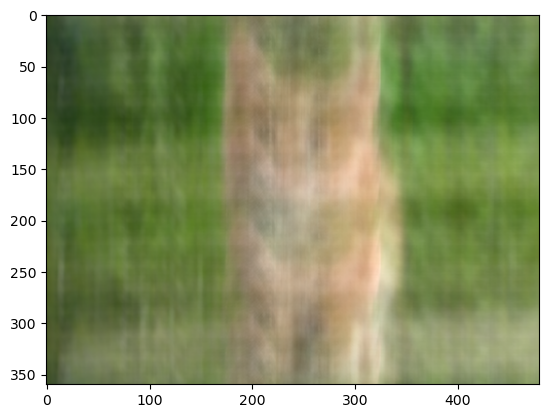

In [171]:
restore = torch.real(torch.sum(w_H.unsqueeze(2)*basis_h ,dim=1,keepdim=False).permute(1,2,0))
print(restore.shape)
print(torch.max(restore), torch.min(restore))
plt.imshow(restore.to(torch.int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([360, 480, 3])
tensor(341.3556) tensor(-96.2280)


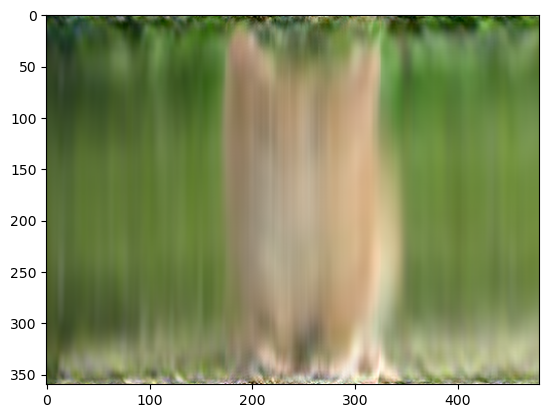

In [172]:
basis_interp_h = torch.stack(list(torch.exp(2j*3.141592*f/H * torch.arange(0,H)) for f in torch.arange(freq_max))).unsqueeze(-1).expand(3, -1,-1,W)
restore = torch.real(torch.sum(w_H_interp.unsqueeze(2)*basis_interp_h ,dim=1,keepdim=False).permute(1,2,0))
print(restore.shape)
print(torch.max(restore), torch.min(restore))
plt.imshow(restore.to(torch.int))

torch.Size([360, 480, 3])
tensor(224.6948) tensor(23.1163)


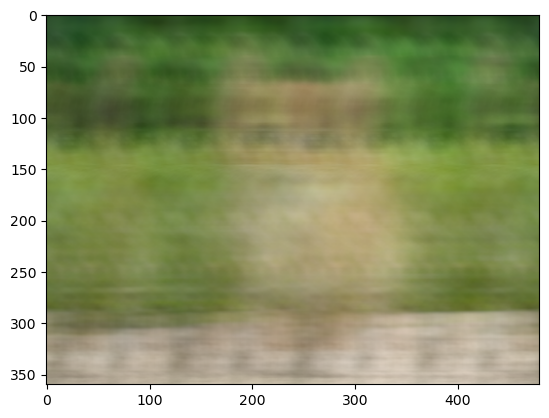

In [173]:
restore = torch.real(torch.sum(W_h.permute(0,2,1).unsqueeze(-1)*basis_w ,dim=1,keepdim=False).permute(1,2,0))
print(restore.shape)
print(torch.max(restore), torch.min(restore))
plt.imshow(restore.to(torch.int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


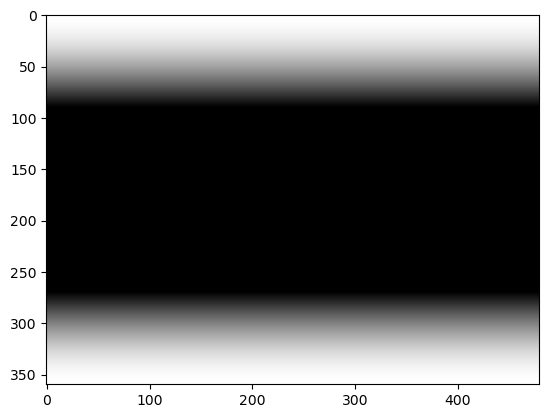

In [174]:
plt.imshow(torch.real(basis_h[:,1,:,:]).permute(1,2,0))

In [175]:
torch.fft.fftfreq(10)

tensor([ 0.0000,  0.1000,  0.2000,  0.3000,  0.4000, -0.5000, -0.4000, -0.3000,
        -0.2000, -0.1000])

In [75]:
torch.fft.fft(torch.cat((torch.ones(5),torch.zeros(5))))

tensor([ 5.0000e+00+0.0000j,  1.0000e+00-3.0777j,  0.0000e+00+0.0000j,
         1.0000e+00-0.7265j, -5.9605e-08-0.0000j,  1.0000e+00+0.0000j,
        -5.9605e-08+0.0000j,  1.0000e+00+0.7265j,  0.0000e+00-0.0000j,
         1.0000e+00+3.0777j])